# Generatives Trainig mit DeepHull und Max-Distanz loss, generatives und normales Netz trainieren unabhängig voneinander
falls noch kein ICNN Netz exisitiert, kann eins gelernt werden, indem man init auf True setzt

In [1]:
import numpy as np
import torch

from script.NeuralNets.Networks import ICNN
from script.NeuralNets.Networks import SequentialNN
from torch.utils.data import DataLoader
from script.dataInit import ConvexDataset, Rhombus
from script.NeuralNets.trainFunction import train_icnn_adversarial, train_icnn
from script.eval import Plots_for


In [2]:
icnn = ICNN([2, 10, 10, 1])
adversarial = SequentialNN([2, 10, 10, 2])
epochs = 30
batch_size = 10

number_of_adversarial_samples = 1000
number_of_train_samples = 1000
hyper_lambda = 1
x_range = [-1.5, 1.5]
y_range = [-1.5, 1.5]

init = False

In [3]:
true_extremal_points = Rhombus().get_extremal_points()
if init:
    included_space, ambient_space = Rhombus().get_uniform_samples(number_of_train_samples, x_range, y_range) #samples will be split in inside and outside the rhombus
    dataset = ConvexDataset(data=included_space)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataset = ConvexDataset(data= ambient_space)
    ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    random_samples = []
    for i in range(number_of_adversarial_samples): # generate random samples
        x = np.random.default_rng().uniform(low=x_range[0], high=x_range[1])
        y = np.random.default_rng().uniform(low=y_range[0], high=y_range[1])
        random_samples.append([[x, y]])

    value = torch.tensor(random_samples, requires_grad=True, dtype=torch.float64)
    adversarial_set = ConvexDataset(data=value)
    adversarial_loader = DataLoader(adversarial_set, batch_size=batch_size, shuffle=True)

if init:
    torch.save(ambient_space, "../../ambient_space.pt")
    torch.save(included_space, "../../included_space.pt")
    torch.save(value, "../../value.pt")
else:
    icnn.load_state_dict(torch.load("../../icnn.pt"), strict=False)
    ambient_space = torch.load("../../ambient_space.pt").to(torch.float64)
    included_space = torch.load("../../included_space.pt").to(torch.float64)
    value = torch.load("../../value.pt").to(torch.float64)
    dataset = ConvexDataset(data=included_space)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataset = ConvexDataset(data=ambient_space)
    ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    adversarial_set = ConvexDataset(data=value)
    adversarial_loader = DataLoader(adversarial_set, batch_size=batch_size, shuffle=True)

TypeError: 'float' object is not subscriptable

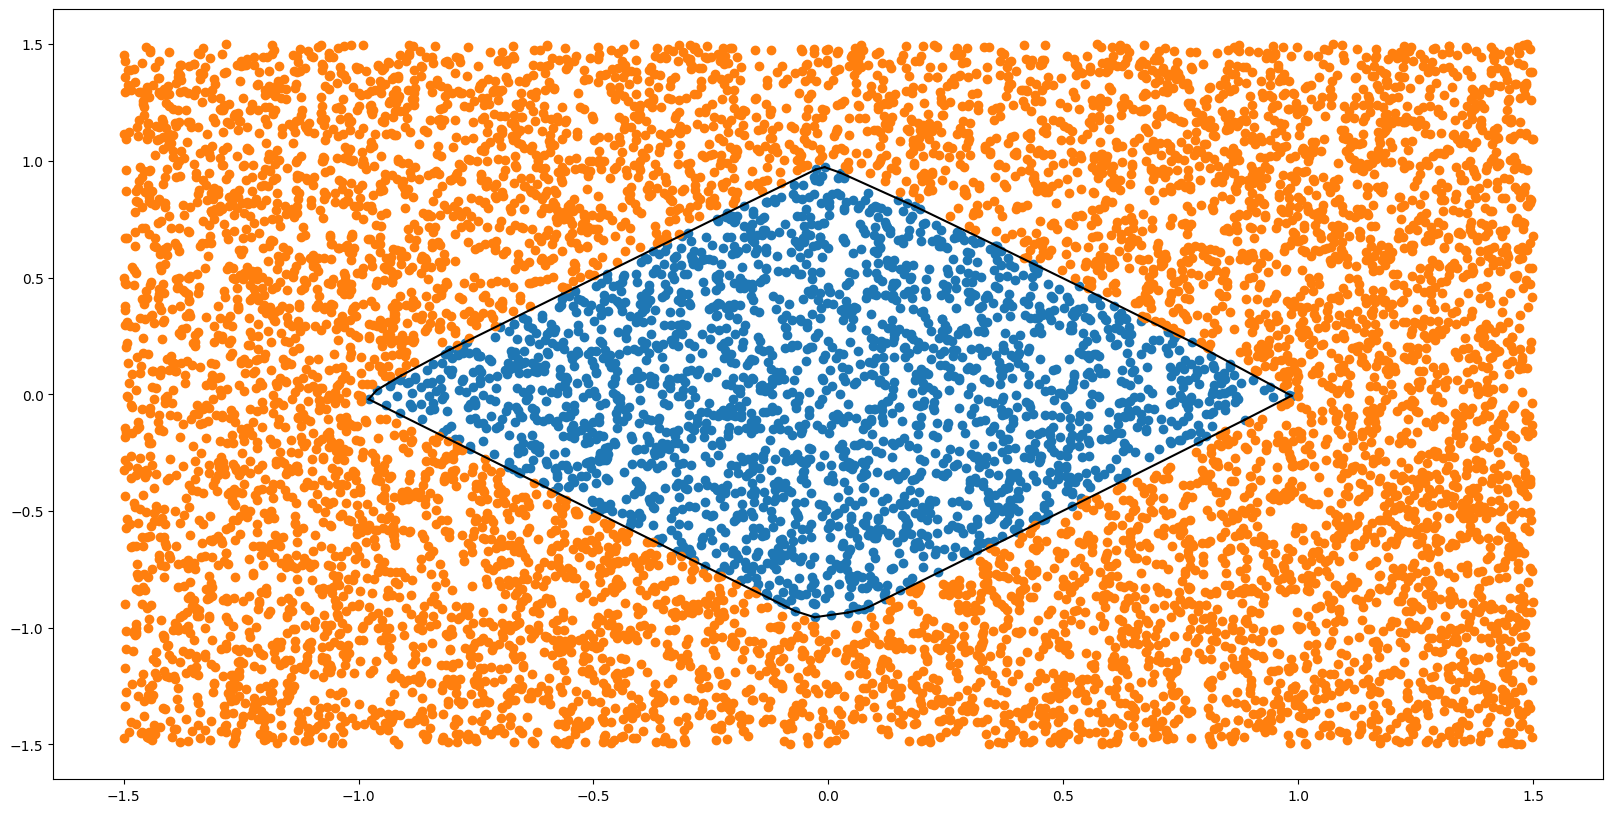

In [4]:
plots = Plots_for(0, icnn, included_space, ambient_space, true_extremal_points, x_range, y_range, adversarial=adversarial, adversarial_values=value)
plots.plt_initial()

plots.plt_adversarial_initial()
plots.plt_adversarial_dotted()

if init:
    history = train_icnn(icnn, train_loader, ambient_loader, epochs=epochs, hyper_lambda=hyper_lambda)
    torch.save(icnn.state_dict(), "../../icnn.pt")
plots.plt_mesh()

=== Epoch: 0===
batch = 0, mean loss = 14.449606331993753, l_pos = 0.22233175888176354, l_neg = 0.0, l_gen = 14.22727457311199
batch = 100, mean loss = 13.036202817845444, l_pos = 0.19809263673620292, l_neg = 0.0, l_gen = 12.838110181109231
batch = 200, mean loss = 11.565070441257468, l_pos = 0.19674787866743515, l_neg = 0.0, l_gen = 11.36832256259003
batch = 221, mean loss = 11.349502957225274, l_pos = 0.19591142368213982, l_neg = 0.0, l_gen = 11.15359153354313
=== Epoch: 1===
batch = 0, mean loss = 8.710952046350432, l_pos = 0.25738226488628324, l_neg = 0.0, l_gen = 8.453569781464148
batch = 100, mean loss = 8.740975007157768, l_pos = 0.19867238943695742, l_neg = 0.0, l_gen = 8.542302617720813
batch = 200, mean loss = 8.525198272793267, l_pos = 0.19652054749689707, l_neg = 0.0, l_gen = 8.328677725296371
batch = 221, mean loss = 8.481332324219085, l_pos = 0.1959114236821399, l_neg = 0.0, l_gen = 8.285420900536947
=== Epoch: 2===
batch = 0, mean loss = 7.773922875127587, l_pos = 0.2061

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

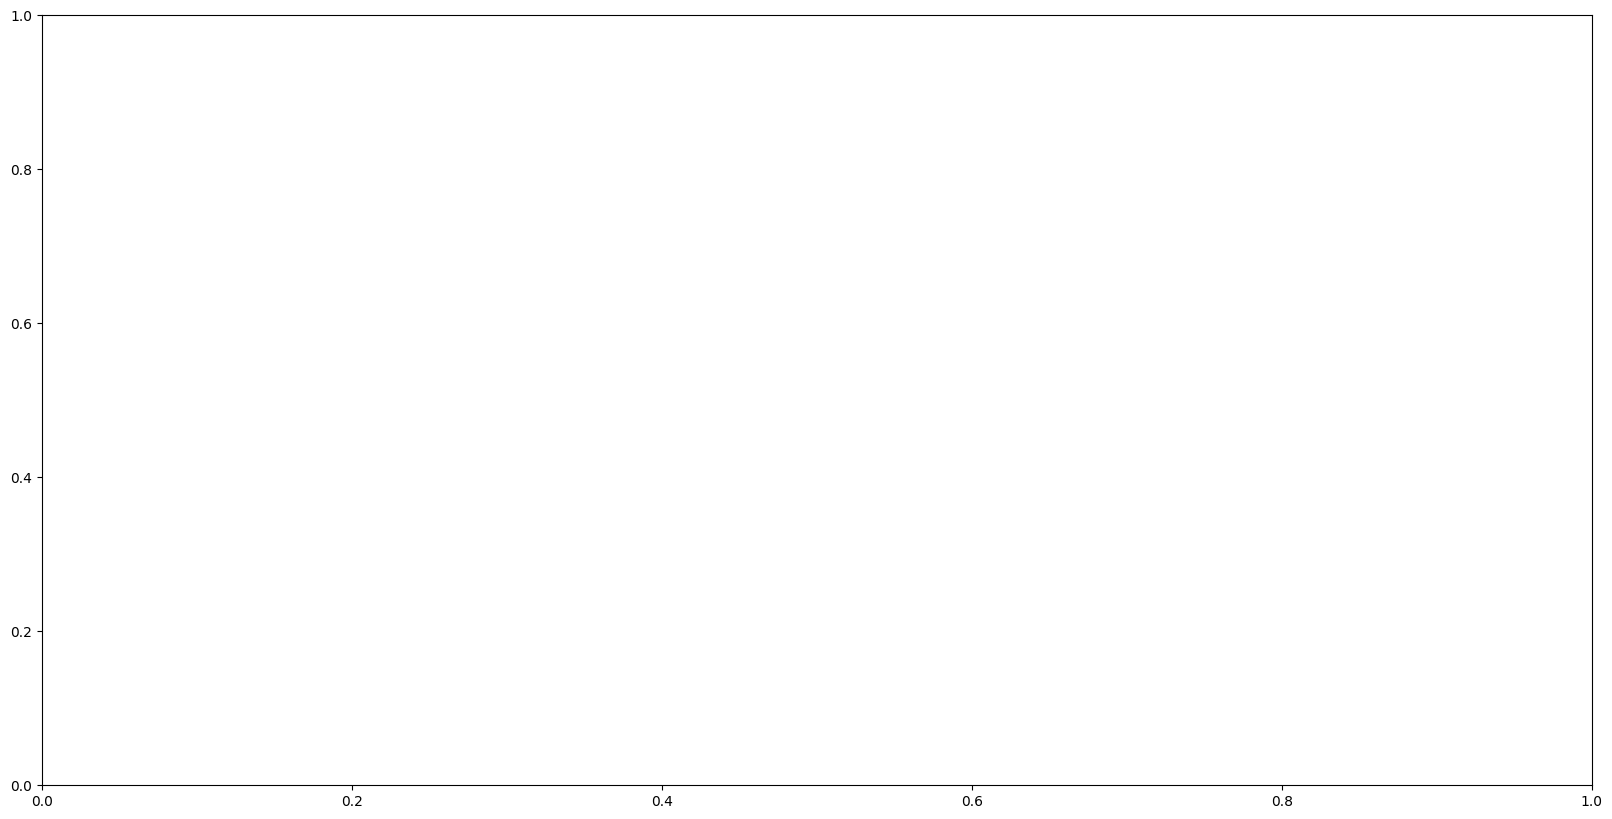

In [6]:
for i in range(int(epochs / 10)):
    history = train_icnn_adversarial(icnn, adversarial, train_loader, adversarial_loader, epochs=10, train_icnn=False, hyper_lambda=hyper_lambda, use_max_distance=True)
    print("run {}".format(i))
    plots.plt_adversarial_dotted()